In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from rfpimp import *
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

## Data import

In [21]:
# Real links
fin = pd.read_csv('data/Real_links.csv')

In [22]:
# Fake links
file = pd.read_csv('data/fake_all.csv')

In [23]:
file.head()

,0,1,2,3,4,5,6,7,8,9
0,addictinginfo,independent,theweek,businessinsider,express,google,NaN,NaN,NaN,NaN
1,nytimes,vox,addictinginfo,nbcnews,whatthefuckjusthappenedtoday,theguardian,cnn,wikipedia,factcheck,thehill
2,addictinginfo,wikipedia,newsweek,milwaukeemag,pinterest,opensecrets,nationalmemo,reverseshot,amgreatness,google
3,newsweek,theatlantic,nationalreview,nytimes,nymag,theguardian,wikipedia,wikipedia,whitehouse,nbcnews
4,nytimes,theguardian,npr,washingtontimes,washingtontimes,wsj,wsj,cnn,newsweek,dailymail


In [24]:
file['label'] = 0

In [25]:
combined = pd.concat([fin,file])
combined = combined.fillna('Unknown')

In [26]:
combined.head()

,0,1,2,3,4,5,6,7,8,9,label
0,bbc,reuters,youtube,youtube,jpost,newsweek,nytimes,expressdigest,investing,wetinhappen,1
1,reuters,jpost,refworld,wikipedia,aljazeera,npr,theguardian,cbsnews,cfr,wsj,1
2,reuters,wikipedia,wikipedia,antiwar,dailymail,google,theautomaticearth,crediblecarbon,hurriyetdailynews,theguardian,1
3,reuters,reddit,nytimes,nytimes,cnn,theatlantic,newyorker,bbc,scmp,business-standard,1
4,reuters,nytimes,wikipedia,go,irishtimes,twitter,theguardian,wsj,dailymail,dw,1


In [27]:
def flatten(X):
    """
    function to flatten a list
    """
    flat_list = []
    for sublist in X.values:
        for item in sublist:
            flat_list.append(item)
    return flat_list

In [28]:
def plot(flat_list):
    """
    function to plot bar chart
    """
    l1 =[]
    l2 = []
    for i in Counter(flat_list).most_common(15):
        l1.append(i[0])
        l2.append(i[1])
    plt.bar(l1,l2)
    plt.xticks(rotation=90)

In [29]:
real = combined.loc[combined['label']==1]
real = real.iloc[:,:-1]
fake = combined.loc[combined['label']==0]
fake = fake.iloc[:,:-1]

## EDA

## Real Links

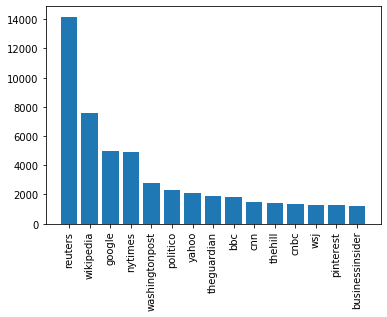

In [30]:
plot(flatten(real))

## Fake Links

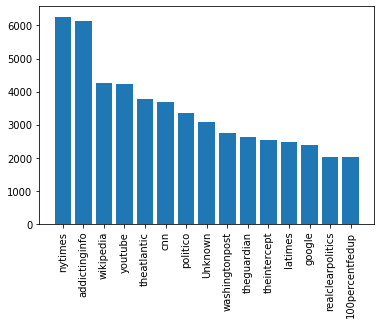

In [31]:
plot(flatten(fake))

In [32]:
# Combined csv
combined.to_csv('Training_data.csv', index=False)

In [33]:
y = combined['label']
X = combined[['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']]

In [34]:
flat_list = flatten(X)

In [35]:
# Encoding
links = list(set(flat_list))
links_dict = {links[i]:i for i in range(len(links))}
for i in X.columns:
    X[i] = X[i].apply(lambda x: links_dict[x])

In [36]:
X.head()

,0,1,2,3,4,5,6,7,8,9
0,7052,6471,1438,1438,5394,2849,2765,93,547,10135
1,6471,5394,891,2913,4173,7078,3994,575,5748,5566
2,6471,2913,2913,2851,10482,2006,7047,5319,3692,3994
3,6471,7265,2765,2765,5537,8950,1329,7052,6944,10735
4,6471,2765,2913,3589,1905,8028,3994,5566,10482,1220


## Model - RF

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
model = RandomForestClassifier(n_estimators=100, bootstrap=True, min_samples_leaf = 5,
                               random_state=42, n_jobs = -1, oob_score= True)
model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [39]:
y_pred = model.predict(X_test)

In [40]:
accuracy_score(y_test,y_pred)

0.9773611111111111

## Cross-validation

In [41]:
scores = cross_val_score(model, X, y, cv=5)

In [42]:
scores

array([0.98875   , 0.98041667, 0.975     , 0.97333333, 0.97416667])

## Feature importance

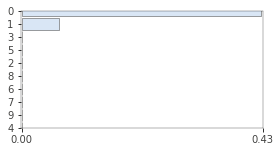

In [43]:
imp = importances(model, X_test, y_test, n_samples=-1)
viz = plot_importances(imp)
viz.view()

### Google search domains

In [5]:
import pandas as pd
import tldextract
import googlesearch
import time
import re
import requests
from bs4 import BeautifulSoup
import multiprocessing as mp

In [13]:
def google_query(query, num_results = 10,header = {'User-agent': 'your bot 0'}):
    time.sleep(2)
    query_str = query.replace(" ","+")
    site = 'https://www.google.com/search?q=' + query
    search_page = requests.get(site, headers = header)
    search_soup = BeautifulSoup(search_page.text)
    links = search_soup.findAll("a")
    all_links = []
    for link in search_soup.find_all("a",href=re.compile("(?<=/url\?q=)(htt.*://.*)"))[0:num_results]:
        all_links.extend(re.split(":(?=http)",link["href"].replace("/url?q=","")))
    result = [tldextract.extract(link).domain for link in all_links]
    return result

In [15]:
res = google_query('potato monster')

In [19]:
pd.DataFrame(res).T

,0,1,2,3,4,5,6,7,8,9
0,fandom,fandom,fandom,fandom,fandom,littlepotatoes,littlepotatoes,youtube,youtube,facebook


In [44]:
import pickle 
# Save the trained model as a pickle string. 
saved_model = pickle.dump(model, open('domain_model', 'wb')) 
saved_vocab = pickle.dump(links_dict, open('links_vocab', 'wb'))